<a href="https://colab.research.google.com/github/ravi-gopalan/breast_cancer_histopathology/blob/master/breast_cancer_image_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pwd

'/content'

In [0]:
!mkdir breast_cancer_analysis

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
cd /root

/root


In [0]:
!mkdir .kaggle

In [0]:
!cp '/content/gdrive/My Drive/Colab_stuff/kaggle.json' /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [7]:
cd /content/breast_cancer_analysis

/content/breast_cancer_analysis


In [8]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images -p /content/breast_cancer_analysis

 99% 1.48G/1.49G [00:27<00:00, 64.7MB/s]
100% 1.49G/1.49G [00:27<00:00, 58.4MB/s]


In [9]:
!ls -la

total 1560716
drwxr-xr-x 2 root root       4096 Jun  3 22:15 .
drwxr-xr-x 1 root root       4096 Jun  3 22:14 ..
-rw-r--r-- 1 root root 1598158593 Jun  3 22:15 breast-histopathology-images.zip


In [10]:
!unzip breast-histopathology-images.zip

Archive:  breast-histopathology-images.zip
  inflating: IDC_regular_ps50_idx5.zip  


In [11]:
!ls -la

total 3167060
drwxr-xr-x 2 root root       4096 Jun  3 22:16 .
drwxr-xr-x 1 root root       4096 Jun  3 22:14 ..
-rw-r--r-- 1 root root 1598158593 Jun  3 22:15 breast-histopathology-images.zip
-rw-r--r-- 1 root root 1644892042 Dec 19  2017 IDC_regular_ps50_idx5.zip


In [0]:
!unzip -q IDC_regular_ps50_idx5.zip

In [13]:
!ls -la

total 3168184
drwxr-xr-x 281 root root      12288 Jun  3 22:21 .
drwxr-xr-x   1 root root       4096 Jun  3 22:14 ..
drwx------   4 root root       4096 Mar 13  2014 10253
drwx------   4 root root       4096 Mar 13  2014 10254
drwx------   4 root root       4096 Mar 13  2014 10255
drwx------   4 root root       4096 Mar 13  2014 10256
drwx------   4 root root       4096 Mar 13  2014 10257
drwx------   4 root root       4096 Mar 13  2014 10258
drwx------   4 root root       4096 Mar 13  2014 10259
drwx------   4 root root       4096 Mar 13  2014 10260
drwx------   4 root root       4096 Mar 13  2014 10261
drwx------   4 root root       4096 Mar 13  2014 10262
drwx------   4 root root       4096 Mar 13  2014 10264
drwx------   4 root root       4096 Mar 13  2014 10268
drwx------   4 root root       4096 Mar 13  2014 10269
drwx------   4 root root       4096 Mar 13  2014 10272
drwx------   4 root root       4096 Mar 13  2014 10273
drwx------   4 root root       4096 Mar 13  2014 10274
drw

In [0]:
!rm breast-histopathology-images.zip
!rm IDC_regular_ps50_idx5.zip

In [15]:
!ls

10253  10288  12810  12881  12930  13403  14153  15513	16554  8980  9174  9291
10254  10290  12811  12882  12931  13404  14154  15514	16555  8984  9175  9319
10255  10291  12817  12883  12932  13458  14155  15515	16568  9022  9176  9320
10256  10292  12818  12884  12933  13459  14156  15516	16569  9023  9177  9321
10257  10293  12819  12886  12934  13460  14157  15632	16570  9029  9178  9322
10258  10295  12820  12890  12935  13461  14188  15633	16895  9035  9181  9323
10259  10299  12821  12891  12947  13462  14189  15634	16896  9036  9225  9324
10260  10300  12822  12892  12948  13591  14190  15839	8863   9037  9226  9325
10261  10301  12823  12893  12949  13613  14191  15840	8864   9041  9227  9344
10262  10302  12824  12894  12951  13616  14192  15902	8865   9043  9228  9345
10264  10303  12826  12895  12954  13617  14209  15903	8867   9044  9250  9346
10268  10304  12867  12896  12955  13666  14210  16014	8913   9073  9254  9347
10269  10305  12868  12897  13018  13687  14211  160

In [17]:
import os
from pathlib import Path
import shutil
import glob
from PIL import Image, ImageFile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns


from sklearn.datasets import load_files
from keras.utils import np_utils

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


from tqdm import tqdm


from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential, Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, History, CSVLogger
from keras.applications import vgg16, inception_v3, resnet50, mobilenet, xception

from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import f1_score, fbeta_score, roc_curve, cohen_kappa_score
from sklearn.metrics import auc, roc_auc_score, precision_recall_curve

from sklearn.model_selection import StratifiedShuffleSplit


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
# data path
base_dir = Path('/content/breast_cancer_analysis')

In [25]:
cd /content/breast_cancer_analysis

/content/breast_cancer_analysis


In [23]:
cd 0

/content/breast_cancer_analysis/10253/0


In [0]:
result = list(Path(base_dir).glob('**/*.png'))

In [25]:
len(result)

277524

In [26]:
result[:10]

[PosixPath('/content/breast_cancer_analysis/13018/0/13018_idx5_x2301_y601_class0.png'),
 PosixPath('/content/breast_cancer_analysis/13018/0/13018_idx5_x901_y351_class0.png'),
 PosixPath('/content/breast_cancer_analysis/13018/0/13018_idx5_x51_y501_class0.png'),
 PosixPath('/content/breast_cancer_analysis/13018/0/13018_idx5_x2751_y1151_class0.png'),
 PosixPath('/content/breast_cancer_analysis/13018/0/13018_idx5_x2501_y351_class0.png'),
 PosixPath('/content/breast_cancer_analysis/13018/0/13018_idx5_x2351_y251_class0.png'),
 PosixPath('/content/breast_cancer_analysis/13018/0/13018_idx5_x2551_y601_class0.png'),
 PosixPath('/content/breast_cancer_analysis/13018/0/13018_idx5_x1151_y1001_class0.png'),
 PosixPath('/content/breast_cancer_analysis/13018/0/13018_idx5_x2301_y651_class0.png'),
 PosixPath('/content/breast_cancer_analysis/13018/0/13018_idx5_x751_y801_class0.png')]

In [0]:
def check_class(name):
  if name.__contains__('class0'):
    case = 0
  else:
    case = 1
  return case

In [29]:
result[5].is_file()

True

In [30]:
result[5].name

'13018_idx5_x2351_y251_class0.png'

13018_idx5_x2301_y601_class0.png
0
13018_idx5_x901_y351_class0.png
0
13018_idx5_x51_y501_class0.png
0
13018_idx5_x2751_y1151_class0.png
0
13018_idx5_x2501_y351_class0.png
0


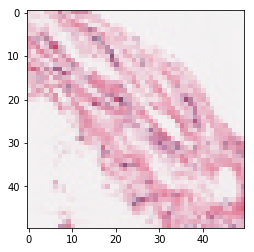

In [35]:
for fname in result[:5]:
  print(fname.name)
  plt.imshow(image.load_img(fname))
  print(check_class(fname.name))